## 0 - import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Standardisation
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# Réduction de dimension
from sklearn.feature_selection import VarianceThreshold, SelectFromModel
from sklearn.linear_model import Lasso
from sklearn.decomposition import PCA

# Evaluation des modèles
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

# Divers
from utils import dataframe_info, racine_projet

In [2]:
df = pd.read_csv(racine_projet()+'/data/processed/ML_data.csv', low_memory = False)

## 1 - Filtre rajoutés

In [3]:
#df= df[df['ResponseDuration'] >= 1]

In [4]:
df = df.drop(columns = ["DeployedFromStation_Name"])

## 2 - Encodage

In [5]:
df_encoded = df

In [6]:
# Encodage binaire : DeployedFromLocation
encoder = LabelEncoder()
df_encoded['DeployedFromLocation'] = encoder.fit_transform(df_encoded['DeployedFromLocation'])

In [7]:
# Encodage getdummies : "PlusCode_Description", "PropertyCategory","AddressQualifier","IncidentType"
cols_to_encode = df_encoded.select_dtypes(include=['object']).columns 
df_encoded = pd.get_dummies(df_encoded, columns=cols_to_encode)

## 3 - train_test_split

In [8]:
target = df_encoded.ResponseDuration
X = df_encoded.drop(labels = ["ResponseDuration"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X,target, test_size=0.2, random_state=42)

## 4 - normalisation (Standard & Minmax)

In [9]:
# Standard OU minmax
# "Northing_rounded","Easting_rounded", "PumpOrder", "NumStationsWithPumpsAttending", "NumPumpsAttending", "NumCalls", "year"
columns_for_scaling = ["Northing_rounded",
                       "Easting_rounded",
                       "PumpOrder",
                       "NumStationsWithPumpsAttending",
                       "NumPumpsAttending",
                       "NumCalls",
                       "year",
                       "rain", # rajoutée
                       "temperature_2m",  # rajoutée
                       "relative_humidity_2m", # rajoutée
                       "weather_code", # rajoutée
                       "wind_speed_10m", # rajoutée
                       "wind_gusts_10m"] # rajoutée
scaler = StandardScaler()
#scaler = MinMaxScaler()

X_train[columns_for_scaling]= scaler.fit_transform(X_train[columns_for_scaling])
X_test[columns_for_scaling] = scaler.transform(X_test[columns_for_scaling])


### Illustrations

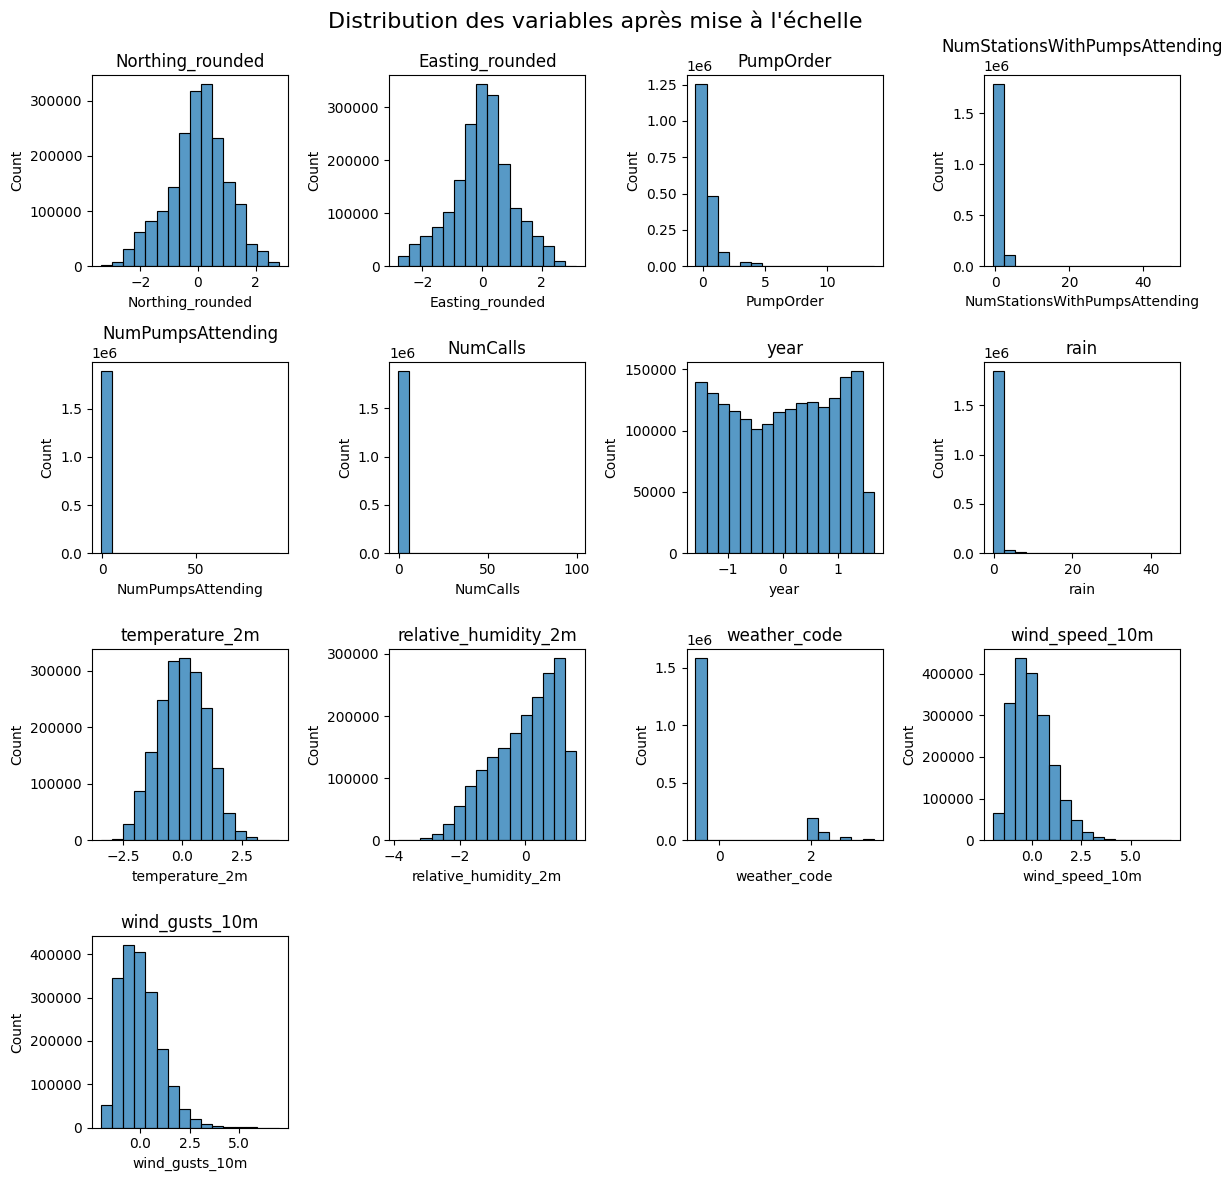

In [10]:
# Afficher la distribution des variables après mise à l'échelle
plt.figure(figsize=(12, 12))
plt.suptitle('Distribution des variables après mise à l\'échelle', fontsize=16)

for i, col in enumerate(columns_for_scaling, start=1):
    plt.subplot(4, 4, i)
    sns.histplot(X_train[col], bins=16)
    plt.title(col)

plt.tight_layout()
plt.show()

In [11]:
dataframe_info(pd.DataFrame(X_train))

,Column,Non-Null Count,NaN Count,NaN Percentage,Dtype,Example Value
0,DeployedFromLocation,1890728,0,0.0,int64,0
1,PumpOrder,1890728,0,0.0,float64,-0.594006
2,Easting_rounded,1890728,0,0.0,float64,0.278521
3,Northing_rounded,1890728,0,0.0,float64,-0.333663
4,NumStationsWithPumpsAttending,1890728,0,0.0,float64,0.352111
...,...,...,...,...,...,...
67,IncidentType_Spills and Leaks (not RTC),1890728,0,0.0,bool,False
68,IncidentType_Stand By,1890728,0,0.0,bool,False
69,IncidentType_Suicide/attempts,1890728,0,0.0,bool,False
70,IncidentType_Use of Special Operations Room,1890728,0,0.0,bool,False


## 5 - Réduction de dimension

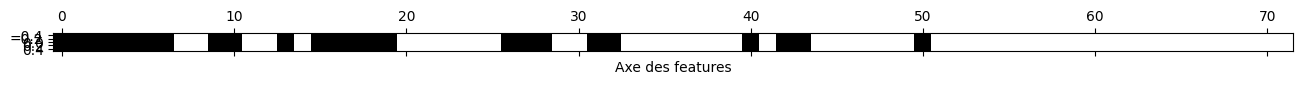

24


In [12]:
## Embedded method
lasso = Lasso(alpha = 1)
model = SelectFromModel(estimator = lasso, threshold = 1e-10)
model.fit(X_train, y_train)

X_train_emb = model.fit_transform(X_train, y_train)
X_test_emb = model.transform(X_test)

mask = model.get_support()
plt.matshow(mask.reshape(1,-1), cmap = 'gray_r')
plt.xlabel('Axe des features');
plt.show();

X_train = X_train_emb
X_test = X_test_emb

print(X_train.shape[1])

## 6 - Machine Learning

### Simple Regression Linéaire

In [13]:
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

r2 = r2_score(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"r^2: {r2}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")

r^2: 0.16339186525241034
Root Mean Squared Error (RMSE): 140.1886675972663
Mean Absolute Error (MAE): 101.43856528846408


### Ridge Regression

In [14]:
from sklearn.linear_model import Ridge

ridge = Ridge()
ridge.fit(X_train, y_train)
y_pred_ridge = ridge.predict(X_test)

r2_ridge = r2_score(y_test, y_pred_ridge)
rmse_ridge = root_mean_squared_error(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)

print(f"Ridge r^2: {r2_ridge}")
print(f"Ridge Root Mean Squared Error (RMSE): {rmse_ridge}")
print(f"Ridge Mean Absolute Error (MAE): {mae_ridge}")

Ridge r^2: 0.16339185038426218
Ridge Root Mean Squared Error (RMSE): 140.18866884297847
Ridge Mean Absolute Error (MAE): 101.43856343659506


### Lasso Regression

In [15]:
from sklearn.linear_model import Lasso

lasso = Lasso()
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = root_mean_squared_error(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)

print(f"Lasso r^2: {r2_lasso}")
print(f"Lasso Root Mean Squared Error (RMSE): {rmse_lasso}")
print(f"Lasso Mean Absolute Error (MAE): {mae_lasso}")

Lasso r^2: 0.15595092553241696
Lasso Root Mean Squared Error (RMSE): 140.8107188194601
Lasso Mean Absolute Error (MAE): 101.76065437022264


### ElasticNet

In [16]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_elastic = elastic_net.predict(X_test)

r2_en = r2_score(y_test, y_pred_elastic)
rmse_en = root_mean_squared_error(y_test, y_pred_elastic)
mae_en = mean_absolute_error(y_test, y_pred_elastic)

print(f"r^2: {r2_en}")
print(f"Root Mean Squared Error (RMSE): {rmse_en}")
print(f"Mean Absolute Error (MAE): {mae_en}")

r^2: 0.11936812613980696
Root Mean Squared Error (RMSE): 143.82986297706728
Mean Absolute Error (MAE): 104.20704609731379


### XGBoost

In [17]:
import xgboost as xgb
from xgboost import XGBRegressor
from xgboost import plot_importance

In [18]:
xgb = XGBRegressor(random_state=42)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

r2_xgb = r2_score(y_test, y_pred)
rmse_xgb = root_mean_squared_error(y_test, y_pred)
mae_xgb = mean_absolute_error(y_test, y_pred)

print(f"r^2: {r2_xgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_xgb}")
print(f"Mean Absolute Error (MAE): {mae_xgb}")

r^2: 0.329063355922699
Root Mean Squared Error (RMSE): 125.54303161587222
Mean Absolute Error (MAE): 86.95122787852921


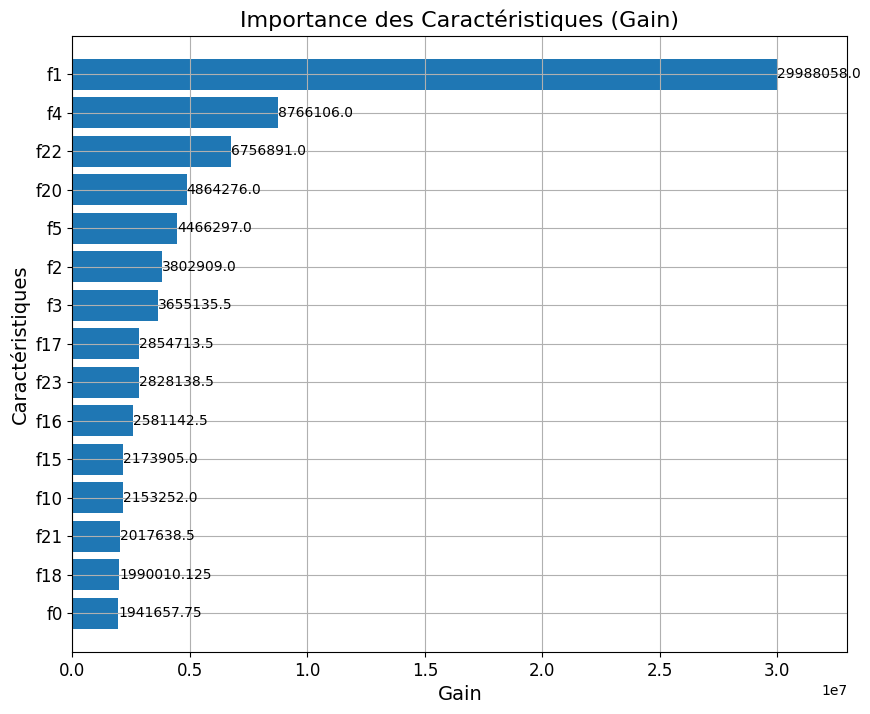

In [19]:
fig, ax = plt.subplots(figsize=(10, 8))  
plot_importance(xgb, importance_type='gain', ax=ax, max_num_features=15, height=0.8)

plt.title('Importance des Caractéristiques (Gain)', fontsize=16)
plt.xlabel('Gain', fontsize=14)
plt.ylabel('Caractéristiques', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


### GridSearch XGBRegressor

In [20]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from xgboost import plot_importance

In [22]:
xgb_model = XGBRegressor(random_state=42)

param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 0.1]
}

grid_search = GridSearchCV(estimator=xgb_model, 
                           param_grid=param_grid, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           n_jobs=-1, 
                           verbose=2)

grid_search.fit(X_train, y_train)

# Afficahege du meilleur score et des meilleurs paramètres
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

# Entraînement avec les meilleurs paramètres
best_xgb = grid_search.best_estimator_
best_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best score: -17231.57588368211


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [23]:
y_pred = best_xgb.predict(X_test)

# Calcul des metrics
r2_bestxgb = r2_score(y_test, y_pred)
rmse_bestxgb = root_mean_squared_error(y_test, y_pred)
mae_bestxgb = mean_absolute_error(y_test, y_pred)

print(f"r^2: {r2_bestxgb}")
print(f"Root Mean Squared Error (RMSE): {rmse_bestxgb}")
print(f"Mean Absolute Error (MAE): {mae_bestxgb}")

r^2: 0.2656537890434265
Root Mean Squared Error (RMSE): 131.34159848536203
Mean Absolute Error (MAE): 92.89037579193193
